<a href="https://colab.research.google.com/github/williammcintosh/machine_learning_projects/blob/main/RAG_Loop_Chroma_v004.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG Loop w/ Chroma + GPT

## Will McIntosh

## Purpose

Reviewing some of the elements in a embeddings-based retreival system and how that fits together in a Retreival Augmented Generation (RAG) loop, together with an LLM.

## How it Works

<center>
    <img src="https://drive.google.com/uc?export=view&id=1QWTIh86_N9z7yDDchozSTeHY1prZBMmF" width="50%">
</center>


The way RAG works is you have some user query which comes in and some set of documents. These documents need to be embedded and stored in your retreival system (in this case we use Chroma). We run the query through the same embedding model (Chroma). The retreival system finds the most relevant document according to the embedding from that query by finding the nearest neighbors embeddings. We return both the query and the relevant documents to the LLM. The LLM synthesizes information from the retrieved documents to generate an answer.

In [1]:
%%capture
! pip install chromadb==0.4.22
! pip install pypdf==3.17.4
! pip install langchain==0.1.0
! pip install sentence_transformers==2.2.2
# ! pip install -U ipykernel==6.28.0
! pip install requests==2.31.0
! pip install openai==1.7.0
# ! pip install umap==0.1.1
# ! pip install umap-learn==0.5.5

In [2]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Helpers

## General Helpers

### General Imports

In [3]:
import requests
from pypdf import PdfReader

### Example PDF

In [4]:
def get_academic_latex_paper():
  pdf_title = 'RR-2757_latex.pdf'
  url = 'https://drive.google.com/uc?export=download&id=1V8OMDVUgzL-FfCNHWlSUkhG-k0jirHMl'

  response = requests.get(url)

  with open(pdf_title, "wb") as f:
      f.write(response.content)

  return pdf_title

In [5]:
def get_microsoft_2022_report():
  pdf_title = '221115247.pdf'
  url = 'https://annualreport.stocklight.com/nasdaq/msft/'+pdf_title

  response = requests.get(url)

  with open(pdf_title, "wb") as f:
      f.write(response.content)

  return pdf_title

## OpenAI Helpers

### OpenAI Imports

In [6]:
import os
import openai
from openai import OpenAI

### OpenAI Keys

In [7]:
api_key_file = '/content/drive/MyDrive/JarvisGPT/gptapi_key.txt'

with open(api_key_file, 'r') as file:
    openai.api_key = file.read().strip()

### OpenAI Prompt

We are turning ChatGPT into a model that retains specific information that is our document.

Different models to select from [can be found here](https://platform.openai.com/docs/models/gpt-3-5).

In [8]:
def rag(query, retrieved_documents, model="gpt-4-1106-preview"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert research assistant. Your users are asking questions about information contained in a document."
            "You will be shown the user's question, and the relevant information from the document. Answer the user's question using only this information."
        },
        {
            "role": "user",
            "content": f"Question: {query}. \n Information: {information}"
        }
    ]

    response = openai.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [9]:
def augment_multiple_query(query, model="gpt-4-1106-preview"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert research assistant. Your users are asking questions about a report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

## Chromadb Helpers

### Chromadb Imports

In [10]:
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
# import umap
from sklearn.decomposition import PCA
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### Chromadb Methods

In [11]:
def convert_pdf_to_chroma_embeddings(pdf_title):
    # Stripping the white space and empty strings or pages
    reader = PdfReader(pdf_title)
    pdf_texts = [p.extract_text().strip() for p in reader.pages if p.extract_text()]

    # Recursively splits chunks based on the separators
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=1000,
        chunk_overlap=0
    )
    character_split_texts = character_splitter.split_text('\n\n'.join(pdf_texts))

    token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

    token_split_texts = []
    for text in character_split_texts:
        token_split_texts += token_splitter.split_text(text)

    # Create Chroma Embeddings
    chroma_client = chromadb.Client()
    chroma_embeddings = chroma_client.create_collection(pdf_title, embedding_function=embedding_function)
    ids = [str(i) for i in range(len(token_split_texts))]
    chroma_embeddings.add(ids=ids, documents=token_split_texts)
    chroma_embeddings.count()

    return chroma_embeddings

In [26]:
def expanded_query_cross_encoder_reranking(original_query, chroma_embeddings):
    augmented_queries = augment_multiple_query(original_query)
    queries = [original_query] + augmented_queries
    results = chroma_embeddings.query(query_texts=queries, n_results=10, include=['documents', 'embeddings'])
    retrieved_documents = results['documents']

    # Deduplicate the retrieved documents
    unique_documents = set()
    for documents in retrieved_documents:
        for document in documents:
            unique_documents.add(document)

    # Get scores for each document
    pairs = [[query, doc] for doc in unique_documents]
    scores = cross_encoder.predict(pairs)
    scored_documents = [(score, doc) for score, doc in zip(scores, unique_documents)]
    sorted_documents = sorted(scored_documents, key=lambda x: x[0], reverse=True)

    # Store the top-ranked documents
    top_docs = []
    for score, document in sorted_documents:
        top_docs.append(document)

    topten_docs = top_docs[:10]
    print(rag(query=queries, retrieved_documents=topten_docs))

    # Create embeddings
    augmented_query_embeddings = embedding_function(augmented_queries)
    original_query_embedding = embedding_function([original_query])
    topten_embeddings = embedding_function(topten_docs)
    result_embeddings = results['embeddings']
    result_embeddings = [item for sublist in result_embeddings for item in sublist]
    dataset_embeddings = chroma_embeddings.get(include=['embeddings'])['embeddings']

    # PCA fit to dataset
    pca = PCA(n_components=2, random_state=0).fit(dataset_embeddings)

    # PCA transform for projections
    projected_augmented_queries = pca.transform(augmented_query_embeddings)
    projected_original_query = pca.transform(original_query_embedding)
    projected_result_embeddings = pca.transform(result_embeddings)
    projected_dataset_embeddings = pca.transform(dataset_embeddings)
    projected_topten_embeddings = pca.transform(topten_embeddings)

    plt.figure()
    plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray', label='Dataset')
    plt.scatter(projected_augmented_queries[:, 0], projected_augmented_queries[:, 1], s=150, marker='X', color='orange', label='Augmented Queries')
    plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='lightgreen', alpha=0.75, label='Retrieved Documents')
    plt.scatter(projected_topten_embeddings[:, 0], projected_topten_embeddings[:, 1], s=100, facecolors='none', edgecolors='green', alpha=1.0, label='Top Ten Documents')
    plt.scatter(projected_original_query[:, 0], projected_original_query[:, 1], s=150, marker='X', color='r', label='Original Query')

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(f'{original_query}')
    plt.axis('off')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

In [12]:
def get_relevant_documents(query, chroma_embeddings):
  results = chroma_embeddings.query(query_texts=[query], n_results=5)
  retrieved_documents = results['documents'][0]
  return retrieved_documents

In [13]:
def chroma_rag_loop(query, chroma_embeddings):

  retrieved_documents = get_relevant_documents(query, chroma_embeddings)

  output = rag(query=query, retrieved_documents=retrieved_documents)

  return output, retrieved_documents

# Call RAG Loop

## Initialize Chromadb

In [14]:
%%capture
# Makes a dense vector embedding
embedding_function = SentenceTransformerEmbeddingFunction()

In [15]:
%%capture
# Get's the 2022 microsoft annual report as example
pdf_title = get_microsoft_2022_report()
chroma_embeddings = convert_pdf_to_chroma_embeddings(pdf_title=pdf_title)

In [16]:
%%capture
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

## Query LLM Example 1

In [17]:
query = "Are Ukrainian employees mentioned?"
output, retrieved_documents = chroma_rag_loop(query, chroma_embeddings)
output

'Yes, Ukrainian employees are mentioned. The information states that the company continues to strive to support their Ukrainian employees and their dependents during the Ukraine crisis with emergency relocation assistance, emergency leave, and other benefits.'

# Query Expansion

<center>
    <img src="https://drive.google.com/uc?export=view&id=1wFLcW5y85_6ESfObw14tY6o4AmyXKbSg" width="50%">
</center>

We can use multiple queries in expaning our query and gain more insights into useful and relevant documents to our query. We use the LLM to generate additional queries that might help us answer our initial question. We take our original query, we pass it into the LLM, we ask the LLM to generate several new related queries to the same original query and then we pass those new queries along with our original query to the RAG system loop.

Generate Multiple Queries and use Cross-Encoder Re-Ranking to find the most relevant documents

Most important factors that contributed to increases in revenue:
- Increase in cash received from customers.
- Growth in various sectors such as cloud services, enterprise services, personal computing, office commercial products, dynamics products, and LinkedIn.
- Increase in Microsoft cloud (formerly commercial cloud) revenue.
- Azure and server products growth.
- Increase in Office 365 commercial and consumer revenue.
- Expansion in Windows OEM and commercial revenue.
- Increase in search and news advertising revenue.

Market expansion impact on revenue growth:
- Ability to reach new users in new markets such as frontline workers, small and medium businesses, and growth markets.
- Increase in Microsoft 365 consumer subscribers indicating market expansion.
- Demand for Microsoft 365 driving Windows commercial products and cloud services revenue.
- Market strength in the commercial PC market reflected in Windows OEM revenue growth.
- Linked to growth in search volume and revenue per se

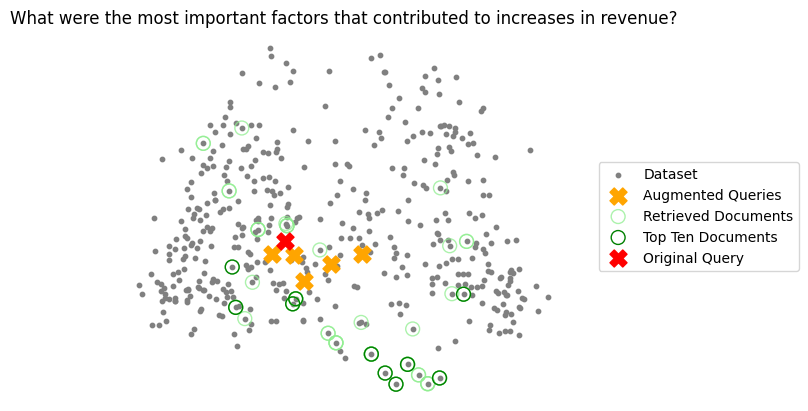

In [27]:
original_query = "What were the most important factors that contributed to increases in revenue?"
expanded_query_cross_encoder_reranking(original_query, chroma_embeddings)

The provided document focuses primarily on Microsoft's business operations, impact on employees, and their responses to various global events, including the war in Ukraine. It does not provide comprehensive information about all aspects of the situation in Ukraine but does mention several related points which can partially answer your questions:

1. How were Ukrainians affected?
The document mentions Microsoft's efforts to "support our Ukrainian employees and their dependents during the Ukraine crisis with emergency relocation assistance, emergency leave, and other benefits." This suggests that Ukrainian employees of Microsoft have been affected to the extent that they require emergency support, though specifics about the wider Ukrainian population are not provided.

2. What is the current population displacement in Ukraine?
The document does not provide information regarding the overall population displacement in Ukraine. It only refers to Microsoft providing emergency relocation assi

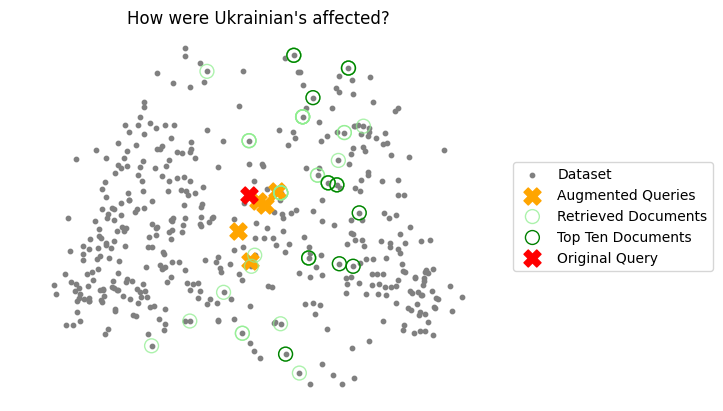

In [28]:
original_query = "How were Ukrainian's affected?"
expanded_query_cross_encoder_reranking(original_query, chroma_embeddings)

# Academic Paper

Here I'm trying the RAG loop with an academic paper that was converted to latex code to preserve algorithms and formulas

1. What's the premise of this document?
- The premise of the document appears to be related to a decision tree structure used for representing testing rules, along with stopping and classification rules in a statistical model, presumably for computer vision or image processing tasks, involving tracking roads or similar features.

2. Who authored the document?
- The authorship of the document is not explicitly provided in the given excerpt.

3. When was the document published?
- The document cites a publication in "computer vision, 11: 2, 109 - 126, 1993." which may suggest the document or related work was published around 1993, but the exact publication date of the document itself isn't stated in the provided information.

4. What scope does the document cover?
- The document covers the topic of constructing decision trees, statistical models for roads and tests, and assumptions for the conditional independence of tests in a statistical distribution. It also seems to include a practica

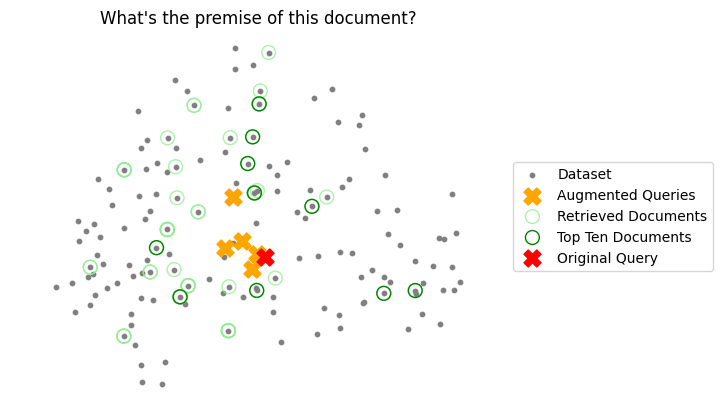

In [29]:
original_query = "What's the premise of this document?"
bruno_latex_paper = get_academic_latex_paper()
chroma_embeddings = convert_pdf_to_chroma_embeddings(pdf_title=bruno_latex_paper)
expanded_query_cross_encoder_reranking(original_query, chroma_embeddings)